Se le brinda la implementación en C del producto matriz-vector para el caso en que los datos están ordenados en memoria por filas (Column-Major). 

Pregunta 1 (7 puntos) 

Pregunta 2 (6 puntos) 

*   Implementar los casos presentados en C en Python.
*   Medir el error relativo de las implementación para comprobar la precisión  a un tamaño de matriz de 1024. Como referencia emplee la operación `dot` proporcionada por el módulo `numpy`.

Pregunta 3 (7 puntos)

* Implementar los casos presentados en C en ensamblador x64. Realizar el análisis temporal para los siguientes valores de N = [ 256, 512, 1024, 2048, 4096]. Reportar una gráfica de N vs tiempo [ms] por cada tipo de arreglo en dónde figuren los resultados del tiempo de ejecución representativo de los 3 algoritmos.
IMPORTANTE: Considerar que para el cálculo del tiempo de ejecución representativo debe tomar la mediana, media armónica o promedio (después del filtro mediano). El número de iteraciones se deja a criterio del alumno.

* Asumir la función más lenta como referencia y calcular el SpeedUP por función para cada N escogido en el item anterior.

Comentarios:

* La pregunta 1 se resuelve durante el laboratorio.
* La pregunta 2 se resuelve durante el laboratorio.
* La pregunta 3 se resuelve de manera asíncrona y se presenta el domingo hasta las 22:00.

## Dependencias

In [ ]:
import numpy as np
import ctypes
import time
from statistics import mean, median
import matplotlib.pyplot as plt

In [ ]:
def filtro_mediana(sign, w):
    signc = []
    lc = sign+sign+sign
    ii = len(sign)
    for i in range(len(sign)):
        izq = i + ii - w//2
        der = i + ii + w//2
        signc.append(median(lc[izq:der+1]))
    return signc

Los datos de memoria caché son los siguientes:

In [ ]:
! lscpu | grep "cache"

L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K


## Column-Major Row-View

In [ ]:
%%file matvecCMRV.c
void matvecCMRV(double *A, double *x, double *b, int N)
{
    float tmp = 0.0;
    for(int i = 0; i < N; i++)
    {
        tmp = 0.0;
        for(int j = 0; j < N; j++)
        {
            tmp += A[i + j*N]*x[j];
        }
        b[i] = tmp;
    }
}

Writing matvecCMRV.c


In [ ]:
! gcc -c -fpic matvecCMRV.c -o matvecCMRV.o
! gcc -shared matvecCMRV.o -o matvecCMRV.so

In [ ]:
def ctypes_matvecCMRV():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecCMRV.so')
    
    # tipo de los argumentos
    lib.matvecCMRV.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecCMRV

In [ ]:
matvecCMRV = ctypes_matvecCMRV()

In [ ]:
n = 2048
A = np.random.rand(n,n)
Y = np.transpose(A).flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
# zeros_like te da un arreglo con las mismas dimensiones que el argumento, pero lleno de zeros
bCMRV = np.zeros_like(bref)
matvecCMRV(Y,x,bCMRV,n)
# error relativo
np.linalg.norm(bref-bCMRV)/np.linalg.norm(bref)

6.265255807731422e-07

## Column-Major Column-View

In [ ]:
%%file matvecCMCV.c
void matvecCMCV(double *A, double *x, double *b, int N)
{
    for(int j = 0; j < N; j++)
    {
        for(int i = 0; i < N; i++)
        {
            b[i] += A[i + j*N]*x[j];
        }
    }
}

Writing matvecCMCV.c


In [ ]:
! gcc -c -fpic matvecCMCV.c -o matvecCMCV.o
! gcc -shared matvecCMCV.o -o matvecCMCV.so

In [ ]:
def ctypes_matvecCMCV():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecCMCV.so')
    
    # tipo de los argumentos
    lib.matvecCMCV.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecCMCV

In [ ]:
matvecCMCV = ctypes_matvecCMCV()

In [ ]:
n = 2048
A = np.random.rand(n,n)
Y = np.transpose(A).flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
# zeros_like te da un arreglo con las mismas dimensiones que el argumento, pero lleno de zeros
bCMCV = np.zeros_like(bref)
matvecCMCV(Y,x,bCMCV,n)
# error relativo
np.linalg.norm(bref-bCMCV)/np.linalg.norm(bref)

1.1740859662277033e-15

## Mediciones

In [ ]:
tcmrv = []
tcmcv = []
ns = 2**np.arange(10,14)
veces = 40
for n in ns:
    tcmrvi = []
    tcmcvi = []
    for j in range(veces):
        # datos
        A = np.random.rand(n,n)
        x = np.random.rand(n,1)
        
        # entradas RM
        Arm = A.flatten()
        
        # entradas CM
        Acm = np.transpose(A).flatten()
        
        # referencia
        bref = np.dot(A,x)
        
        # salidas
        bCMRV = np.zeros_like(bref)
        bCMCV = np.zeros_like(bref)
        
        # tiempo CMRV
        t = time.time()
        matvecCMRV(Acm,x,bCMRV,n)
        tcmrvi.append(time.time() - t)
        
        # tiempo CMCV
        t = time.time()
        matvecCMCV(Acm,x,bCMCV,n)
        tcmcvi.append(time.time() - t)
    
    tcmrv.append(mean(filtro_mediana(tcmrvi,9)))
    tcmcv.append(mean(filtro_mediana(tcmcvi,9)))

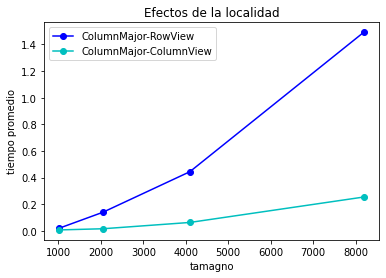

In [ ]:
plt.plot(ns, tcmrv, 'b-o', label='ColumnMajor-RowView')
plt.plot(ns, tcmcv, 'c-o', label='ColumnMajor-ColumnView')
plt.title('Efectos de la localidad')
plt.xlabel('tamagno')
plt.ylabel('tiempo promedio')
plt.legend()
plt.show()

In [ ]:
! rm *.o
! rm *.so
! rm *.c